# Open-Loop Optimal Control

This notebook demonstrates the use of CVXPY for the simulation and computation of open-loop optimal control. The notebook includes a lab exercise.

In [92]:
import numpy as np
import matplotlib.pyplot as plt

## Heater Model

### Model

We will use the two-state model for a single heater/sensor assembly for the calculations that follow.

$$
\begin{align}
C^H_p\frac{dT_{H}}{dt} & = U_a(T_{amb} - T_{H}) + U_b(T_{S} - T_{H}) + \alpha P u\\
C^S_p\frac{dT_{S}}{dt} & = U_b(T_{H} - T_{S}) 
\end{align}
$$

In [93]:
# parameter estimates.
alpha = 0.00016       # watts / (units P * percent U1)
P = 200               # P units
Ua = 0.050            # heat transfer coefficient from heater to environment
CpH = 2.2             # heat capacity of the heater (J/deg C)
CpS = 1.9             # heat capacity of the sensor (J/deg C)
Ub = 0.021            # heat transfer coefficient from heater to sensor
Tamb = 21.0           # ambient temperature

## Simulation

Let's establish a goal of bringing the heater temperature to 60 deg C.  Let's see how well an initial guess at a control strategy will work for us subject to initial conditions

$$
\begin{align*}
T_H(t_0) & = T_{amb} \\
T_S(t_0) & = T_{amb}
\end{align*}
$$

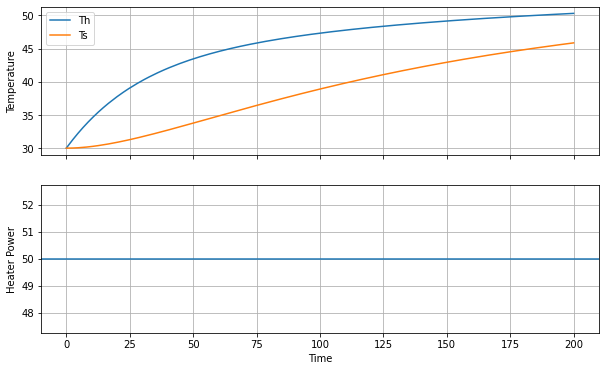

In [96]:
tf = 200
u = 50.0

import pyomo.environ as pyo
import pyomo.dae as dae

m = pyo.ConcreteModel('TCLab Heater/Sensor')

m.t = dae.ContinuousSet(bounds=(0, tf))
m.Th = pyo.Var(m.t)
m.Ts = pyo.Var(m.t)

m.dTh = dae.DerivativeVar(m.Th)
m.dTs = dae.DerivativeVar(m.Ts)

@m.Constraint(m.t)
def heater1(m, t):
    return CpH * m.dTh[t] == Ua *(Tamb - m.Th[t]) + Ub*(m.Ts[t] - m.Th[t]) + alpha*P*u

@m.Constraint(m.t)
def sensor1(m, t):
    return CpS * m.dTs[t] == Ub *(m.Th[t] - m.Ts[t]) 

m.Th[0].fix(30.0)
m.Ts[0].fix(30.0)

pyo.TransformationFactory('dae.collocation').apply_to(m, nfe=50, wrt=m.t)
pyo.SolverFactory('ipopt').solve(m)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].plot(m.t, [m.Th[t]() for t in m.t], label="Th")
ax[0].plot(m.t, [m.Ts[t]() for t in m.t], label="Ts")
ax[0].legend()
ax[0].set_ylabel("Temperature")
ax[0].grid()

ax[1].axhline(u, label="Power")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Heater Power")
ax[1].grid()


## Exercises

1. How well did our guess work? Try different guesses and find a value for $u$ that results in a heater temperature close to the target of 60 deg C.

2. What is the impact of simulation time? Is the value determine in question 1 an answer for the power required for a steady state of 60 deg C.

## Control to a Target


How can we set a target value for $T_h$?

What are the 

* additional decision variable(s)?
* what are the additional constraints?
* what is the objective?
* how to modify the Pyomo model?
* how to modify the visualization?

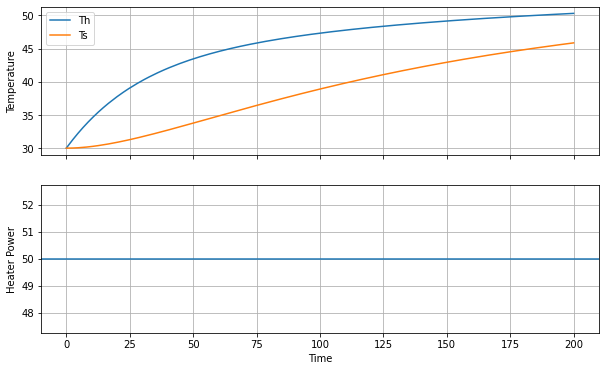

In [98]:
tf = 200
u = 50.0

# Modify this code to find a u so that Th(T_final) = 60.

import pyomo.environ as pyo
import pyomo.dae as dae

m = pyo.ConcreteModel('TCLab Heater/Sensor')

m.t = dae.ContinuousSet(bounds=(0, t_final))
m.Th = pyo.Var(m.t)
m.Ts = pyo.Var(m.t)

m.dTh = dae.DerivativeVar(m.Th)
m.dTs = dae.DerivativeVar(m.Ts)

@m.Constraint(m.t)
def heater1(m, t):
    return CpH * m.dTh[t] == Ua *(Tamb - m.Th[t]) + Ub*(m.Ts[t] - m.Th[t]) + alpha*P*u

@m.Constraint(m.t)
def sensor1(m, t):
    return CpS * m.dTs[t] == Ub *(m.Th[t] - m.Ts[t]) 

m.Th[0].fix(30.0)
m.Ts[0].fix(30.0)

pyo.TransformationFactory('dae.collocation').apply_to(m, nfe=50, wrt=m.t)
pyo.SolverFactory('ipopt').solve(m)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].plot(m.t, [m.Th[t]() for t in m.t], label="Th")
ax[0].plot(m.t, [m.Ts[t]() for t in m.t], label="Ts")
ax[0].legend()
ax[0].set_ylabel("Temperature")
ax[0].grid()

ax[1].axhline(u, label="Power")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Heater Power")
ax[1].grid()


## Optimal Control

Let's consider the whole approach to steady state

$$\min_u \int_{0}^{t_f} \|SP - T_h(t)\|^2 dt$$

Note that `pyomo.dae` has an `Integral` object to help with these situations.

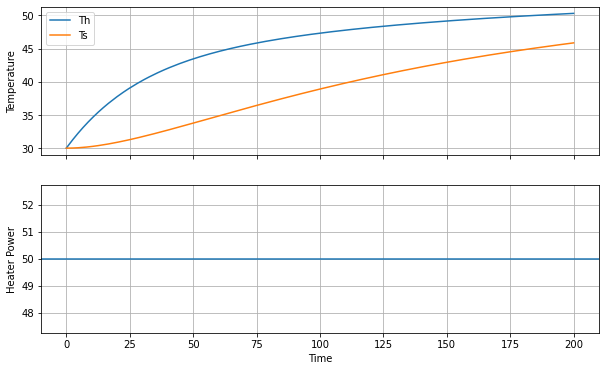

In [99]:
tf = 200
u = 50.0

# Modify this code to find a u so that Th(T_final) = 60.

import pyomo.environ as pyo
import pyomo.dae as dae

m = pyo.ConcreteModel('TCLab Heater/Sensor')

m.t = dae.ContinuousSet(bounds=(0, t_final))
m.Th = pyo.Var(m.t)
m.Ts = pyo.Var(m.t)

m.dTh = dae.DerivativeVar(m.Th)
m.dTs = dae.DerivativeVar(m.Ts)

@m.Constraint(m.t)
def heater1(m, t):
    return CpH * m.dTh[t] == Ua *(Tamb - m.Th[t]) + Ub*(m.Ts[t] - m.Th[t]) + alpha*P*u

@m.Constraint(m.t)
def sensor1(m, t):
    return CpS * m.dTs[t] == Ub *(m.Th[t] - m.Ts[t]) 

m.Th[0].fix(30.0)
m.Ts[0].fix(30.0)

pyo.TransformationFactory('dae.collocation').apply_to(m, nfe=50, wrt=m.t)
pyo.SolverFactory('ipopt').solve(m)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].plot(m.t, [m.Th[t]() for t in m.t], label="Th")
ax[0].plot(m.t, [m.Ts[t]() for t in m.t], label="Ts")
ax[0].legend()
ax[0].set_ylabel("Temperature")
ax[0].grid()

ax[1].axhline(u, label="Power")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Heater Power")
ax[1].grid()



## Feedforward Optimal Control

An optimal control policy minimizes the differences

$$
\begin{align*}
\min_{u} \int_{t_0}^{t_f} \|T_H^{SP}(t) - T_H(t)\|^2\,dt \\
\end{align*}
$$

subject to constraints

$$
\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_c (T_S - T_H) + P u(t) + d(t)\\
C_p^S \frac{dT_S}{dt} & = - U_c (T_S - T_H) 
\end{align*}
$$

initial conditions

$$
\begin{align*}
T_H(t_0) & = T_{amb} \\
T_S(t_0) & = T_{amb}
\end{align*}
$$

and prior knowledge of $d(t)$.

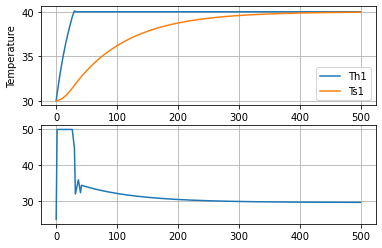

In [75]:

T_final = 500
import pyomo.environ as pyo
import pyomo.dae as dae

m = pyo.ConcreteModel('TCLab Heater/Sensor')

m.t = dae.ContinuousSet(bounds=(0, T_final))
m.Th1 = pyo.Var(m.t)
m.Ts1 = pyo.Var(m.t)
m.u1 = pyo.Var(m.t, bounds=(0, 50))

m.dTh1 = dae.DerivativeVar(m.Th1)
m.dTs1 = dae.DerivativeVar(m.Ts1)

@m.Integral(m.t)
def ise(m, t):
    return (m.Th1[t] - 40.0)**2

@m.Constraint(m.t)
def heater1(m, t):
    return CpH * m.dTh1[t] == Ua *(Tamb - m.Th1[t]) + Ub*(m.Ts1[t] - m.Th1[t]) + alpha*P1*m.u1[t]

@m.Constraint(m.t)
def sensor1(m, t):
    return CpS * m.dTs1[t] == Ub *(m.Th1[t] - m.Ts1[t]) 

m.Th1[0].fix(30.0)
m.Ts1[0].fix(30.0)
                           
@m.Objective(sense=pyo.minimize)
def objective(m):
    return m.ise

pyo.TransformationFactory('dae.collocation').apply_to(m, nfe=50, wrt=m.t)
pyo.SolverFactory('ipopt').solve(m)

fig, ax = plt.subplots(2, 1)

ax[0].plot(m.t, [m.Th1[t]() for t in m.t], label="Th1")
ax[0].plot(m.t, [m.Ts1[t]() for t in m.t], label="Ts1")
ax[0].legend()
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Temperature")
ax[0].grid()

ax[1].plot(m.t, [m.u1[t]() for t in m.t], label="U1")
ax[1].grid()

### Reference Tractory

The reference trajectory is a sequence of ramp/soak intervals.  Python function `r(t)` uses `numpy.interp` to compute values of the reference trajectory at any point in time.

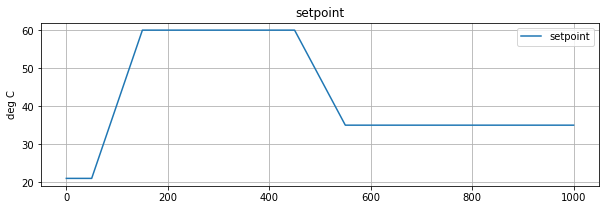

In [9]:
# time grid
tf = 1000
dt = 2
n = round(tf/dt)
t_grid = np.linspace(0, 1000, n+1)

# ambient temperature
Tamb = 21

# setpoint/reference
def r(t):
    return np.interp(t, [0, 50, 150, 450, 550], [Tamb, Tamb, 60, 60, 35])

# plot function
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t_grid, r(t_grid), label="setpoint")
ax.set_title('setpoint')
ax.set_ylabel('deg C')
ax.legend()
ax.grid(True)

## The Control Problem

For the purposes of this notebook, the control problem is to find a control policy $u(t)$ for the interval $0 \leq t \leq t_f$ which causes the output $y(t)$ to track a desired setpoint or reference tracjectory $r(t)$.

The model is recast into linear state space form as

$$
\begin{align}
\frac{dx}{dt} & = A x + B_u u + B_d d \\
y & = C x
\end{align}
$$

where

$$x = \begin{bmatrix} T_{H,1} \\ T_{S,1} \end{bmatrix}
\qquad
u = \begin{bmatrix} u_1 \end{bmatrix}
\qquad
d = \begin{bmatrix} T_{amb} \end{bmatrix}
\qquad
y = \begin{bmatrix} T_{S,1} \end{bmatrix}$$

and

$$A = \begin{bmatrix} -\frac{U_a+U_b}{C^H_p} & \frac{U_b}{C^H_p} \\ \frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p} \end{bmatrix}
\qquad
B_u = \begin{bmatrix} \frac{\alpha P_1}{C^H_p} \\ 0 \end{bmatrix}
\qquad
B_d = \begin{bmatrix} \frac{U_a}{C_p^H} \\ 0 \end{bmatrix}
\qquad
C = \begin{bmatrix} 0 & 1 \end{bmatrix}$$

### Parameter Values

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

# parameter estimates.
alpha = 0.00016       # watts / (units P * percent U1)
P1 = 200              # P units
P2 = 100              # P units
Ua = 0.050            # heat transfer coefficient from heater to environment
CpH = 2.2             # heat capacity of the heater (J/deg C)
CpS = 1.9             # heat capacity of the sensor (J/deg C)
Ub = 0.021            # heat transfer coefficient from heater to sensor

# state space model
A = np.array([[-(Ua + Ub)/CpH, Ub/CpH], [Ub/CpS, -Ub/CpS]])
Bu = np.array([[alpha*P1/CpH], [0]])     # single column
Bd = np.array([[Ua/CpH], [0]])           # single column
C = np.array([[0, 1]])                   # single rowe

### Guessing a Solution

So what should $u(t)$ be?  

The next cell defines process inputs $d(t)$ and $u(t)$. For this disturbance, the model parameters given above, do you think this control policy will cause $y(t)$ to be close to the reference trajectory?

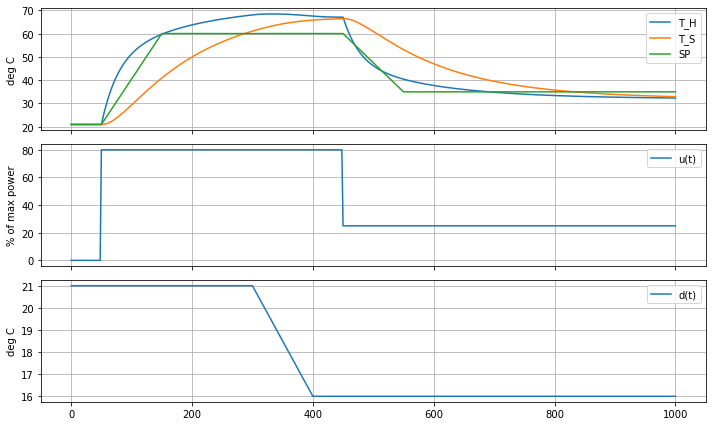

In [56]:
# create a dictionary of unknowns indexed by time
x = {t: cp.Variable(2) for t in t_grid}
y = {t: cp.Variable(1) for t in t_grid}

# trivial objective
objective = cp.Minimize(0)

# model equation and initial condition
model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@[u(t-dt)] + Bd@[d(t-dt)]) for t in t_grid[1:]]
output = [y[t] == C@x[t] for t in t_grid]
IC = [x[0] == np.array([Tamb, Tamb])]

# create and solve optimization problem
problem = cp.Problem(objective,  model + IC + output)
problem.solve()

# display solution
fix, ax = plt.subplots(3, 1, figsize=(10,6), sharex=True)
ax[0].plot(t_grid, [x[t][0].value  for t in t_grid], label="T_H")
ax[0].plot(t_grid, [x[t][1].value  for t in t_grid], label="T_S")
ax[0].plot(t_grid, [r(t) for t in t_grid], label="SP")
ax[0].set_ylabel("deg C")
ax[0].legend()
ax[1].plot(t_grid, [u(t) for t in t_grid], label="u(t)")
ax[1].set_ylabel("% of max power")
ax[2].plot(t_grid, [d(t) for t in t_grid], label="d(t)")
ax[2].set_ylabel("deg C")
for a in ax:
    a.grid(True)
    a.legend()
plt.tight_layout()

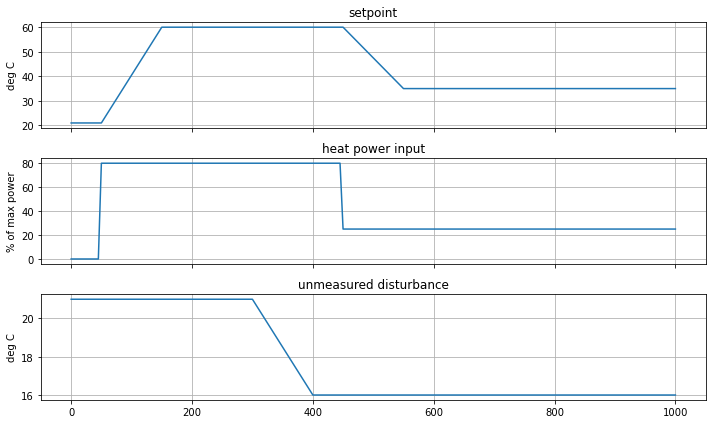

In [55]:
def d(t):
    return np.interp(t, [0, 300, 400], [Tamb, Tamb, Tamb-5])

def u(t):
    return np.interp(t, [ 0, 50, 50, 450, 450], [ 0,  0, 80,  80,  25])

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 6))
ax[0].plot(t, r(t))
ax[0].set_title('setpoint')
ax[0].set_ylabel('deg C')

ax[1].plot(t, u(t))
ax[1].set_title('heat power input')
ax[1].set_ylabel('% of max power')

ax[2].plot(t, d(t))
ax[2].set_title('unmeasured disturbance')
ax[2].set_ylabel('deg C')

for a in ax:
    a.grid(True)
plt.tight_layout()

<hr>

**Study Question:** Evaluate how well this control policy performed. Keep in mind that the objective is for $T_S$ to track the reference input (i.e., the setpoint) as closely as possible. Did the controller achieve the desired steady-state? What about the prior ramp and soak periods? 

**Study Question:** Edit the cells above to change $u(t)$ in to produce a response closer to the target. Make at least 3 attempts. What changes did you make, and were you able to get a better result.

**Study Question:** What criteria could you use to determine if one control policy was better than another? Give at least three examples of possible criteria.

<hr>

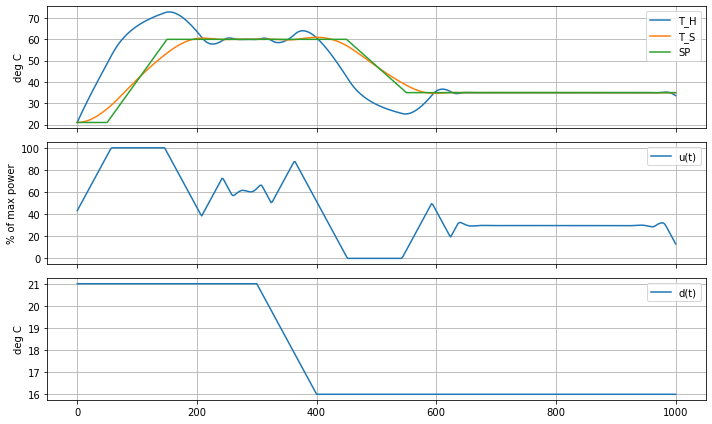

In [61]:
# add $u$ as a decision variable
u = {t: cp.Variable(1, nonneg=True) for t in t_grid}
x = {t: cp.Variable(2) for t in t_grid}
y = {t: cp.Variable(1) for t in t_grid}

# least-squares optimization objective
objective = cp.Minimize(sum((y[t]-r(t))**2 for t in t_grid))

model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[d(t-dt)]) for t in t_grid[1:]]
output = [y[t] == C@x[t] for t in t_grid]
inputs = [u[t] <= 100 for t in t_grid]
IC = [x[0] == np.array([Tamb, Tamb])]
rate = [cp.abs(u[t] - u[t-dt]) <= dt*1 for t in t_grid[1:]]

problem = cp.Problem(objective,  model + IC + output + inputs + rate)
problem.solve()

# display solution
fix, ax = plt.subplots(3, 1, figsize=(10,6), sharex=True)
ax[0].plot(t_grid, [x[t][0].value  for t in t_grid], label="T_H")
ax[0].plot(t_grid, [x[t][1].value  for t in t_grid], label="T_S")
ax[0].plot(t_grid, [r(t) for t in t_grid], label="SP")
ax[0].set_ylabel("deg C")
ax[0].legend()
ax[1].plot(t_grid, [u[t].value for t in t_grid], label="u(t)")
ax[1].set_ylabel("% of max power")
ax[2].plot(t_grid, [d(t) for t in t_grid], label="d(t)")
ax[2].set_ylabel("deg C")
for a in ax:
    a.grid(True)
    a.legend()
plt.tight_layout()

<hr>

**Study Question:** The optimal control computed above requires rapid changes in power level. In process systems where control action requires movement of a valve stem position, there are often limits on how fast the manipulated variable can change. Modify the model to include differential inequalities that limit the time rate of change of control.

$$
\begin{align*}
\frac{du}{dt} & \leq \dot{u}_{max} \\
\frac{du}{dt} & \geq -\dot{u}_{max}
\end{align*}
$$

where $\dot{u}_{max}$ is the maximum rate of change. Add these rate constraints to the problem above. Specify that the maximum power cannot change more than  1% per second.

How does that change the response?

**Study Question:** Change the objective so that the goal is to guide the heater (insteady of the sensor) temperature to the reference trajectory. How does the control policy change? Explain what you observe.

<hr>

## Lab Assignment 8

The goal of this lab assignment is to extend the calculations shown above to the case of the four-state models with two manipulable inputs and independent setpoint functions for $T_{S,1}$ and $T_{S,2}$.

### Exercise 1

In a new cell, create reference inputs for sensor temperatures $T_{S,1}$ and $T_{S,2}$. The new reference trajectories should 

* Set the final time to 800 seconds. 
* Use the same ramp/soak specifications as above for $T_{S,1}$
* For $T_{S,2}$, delay the ramp by 100 seconds, and set the soak temperature to 45C. The high temperature soak period should remain the same. The slopes of the ramps should remain the same. Plot your results.

### Exercise 2

Set up and solve for the heater control policies minimizing the sum of least squares between the sensor temperatures and reference trajectories. Create functions U1(t) and U2(t) that interpolate the solutions for u1(t) and u2(t) for any value of t. Plot the results.

### Exercise 3

Apply the functions U1(t) and U2(t) to your hardware and compare the measured sensor temperatures to those predicted in Exercise 2. How did you do?